In [153]:
import pandas as pd
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import umap.plot

import SEACells
import h5py
import collections
import scipy.sparse as sp_sparse
from scipy.sparse import csr_matrix
import scanpy as sc
import anndata

In [221]:
dataset_dir = '../../data/'
save_dir = '../../data/NGJ/'
dataset = "NGJ/NGJ_experiment_2_filtered_feature_bc_matrix.h5"
switch_dataset = "switch_genelist.csv"
gene_length_dataset = "gene_len_2.csv"

# Read switches

In [224]:
switch_df = pd.read_csv(dataset_dir + switch_dataset, index_col=0)
# drop first column
switch_df = switch_df.drop(switch_df.columns[0], axis=1)

# switch df to dict
switch_dict = {}
for row in switch_df.index:
	switch_dict[row] = switch_df.loc[row].dropna().tolist()

# Read Reference Matrix

In [225]:
adata = sc.read_10x_h5(dataset_dir + dataset)
adata

/Users/CJChen/Desktop/PeerLab/probablistic-model/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/CJChen/Desktop/PeerLab/probablistic-model/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 1905 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [226]:
# make var names unique
adata.var_names_make_unique()

In [227]:
raw_ad = sc.AnnData(adata.X)
raw_ad.obs_names, raw_ad.var_names = adata.obs_names, adata.var_names
adata.raw = raw_ad

In [228]:
# compute highly variable cells
sc.pp.normalize_per_cell(adata, copy=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3660, subset=False) # n_top_genes = 36601 * 0.1
highly_variable_genes = adata.var['highly_variable']

In [229]:
# reset raw data
adata.X = adata.raw.X[:, :]

In [231]:
# load gene length data
gene_length = pd.read_csv(dataset_dir + gene_length_dataset).T
gene_length.columns = ['gene_length']
gene_length = gene_length.drop(gene_length.index[0])
gene_length.head()

,gene_length
ENSG00000243485,1556
ENSG00000237613,1528
ENSG00000186092,6167
ENSG00000238009,44429
ENSG00000239945,1555


In [233]:
# Extract gene expression matrix
gene_expr_matrix = adata.X
# Convert the gene expression matrix to a pandas DataFrame
gene_expr_df = pd.DataFrame.sparse.from_spmatrix(gene_expr_matrix, index=adata.obs_names, columns=adata.var['gene_ids']).T

# add gene name column
gene_expr_df['gene_name'] = adata.var_names

# Ensure both index names match for merging
gene_expr_df.index.name = 'gene_ids'
gene_length.index.name = 'gene_ids'

# Merge gene expression with gene lengths based on gene IDs
merged_data = pd.merge(gene_expr_df, gene_length, left_index=True, right_index=True)
merged_data.head()

,AAACCCAAGCAGCACA-1,AAACGAAAGACCGTTT-1,AAACGAAAGGGCGAAG-1,AAACGCTTCCTCGCAT-1,AAAGAACAGGGAGGAC-1,AAAGGATCATACCATG-1,AAAGGATTCTCGACGG-1,AAAGGGCTCAGCTAGT-1,AAAGGTACAGGTTCAT-1,AAAGGTAGTCCCAAAT-1,...,TTTGATCGTTATCTGG-1,TTTGGAGCAAATGATG-1,TTTGGAGGTATGTCAC-1,TTTGGAGGTGCCTGAC-1,TTTGGAGTCAAATGCC-1,TTTGGTTGTCACGTGC-1,TTTGTTGGTGACACAG-1,TTTGTTGTCAAATGAG-1,gene_name,gene_length
gene_ids,,,,,,,,,,,,,,,,,,,,,
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,MIR1302-2HG,1556
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,FAM138A,1528
ENSG00000186092,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,OR4F5,6167
ENSG00000238009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,AL627309.1,44429
ENSG00000239945,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,AL627309.3,1555


In [234]:
# Calculate RPKM + 1
total_reads = merged_data.iloc[:, :-2].sum(axis=0)
rpkm = (merged_data.iloc[:, :-2].div(merged_data['gene_length'], axis=0) * 1e9).div(total_reads, axis=1) + 1

In [235]:
rpkm.index = merged_data['gene_name']
rpkm.head()

,AAACCCAAGCAGCACA-1,AAACGAAAGACCGTTT-1,AAACGAAAGGGCGAAG-1,AAACGCTTCCTCGCAT-1,AAAGAACAGGGAGGAC-1,AAAGGATCATACCATG-1,AAAGGATTCTCGACGG-1,AAAGGGCTCAGCTAGT-1,AAAGGTACAGGTTCAT-1,AAAGGTAGTCCCAAAT-1,...,TTTGATCCAATGCTCA-1,TTTGATCCATGACAAA-1,TTTGATCGTTATCTGG-1,TTTGGAGCAAATGATG-1,TTTGGAGGTATGTCAC-1,TTTGGAGGTGCCTGAC-1,TTTGGAGTCAAATGCC-1,TTTGGTTGTCACGTGC-1,TTTGTTGGTGACACAG-1,TTTGTTGTCAAATGAG-1
gene_name,,,,,,,,,,,,,,,,,,,,,
MIR1302-2HG,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
FAM138A,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
OR4F5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AL627309.1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AL627309.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [236]:
# save RPKM for future reference
# rpkm.to_csv(save_dir + 'rpkm.csv', sep='\t')

# Clustering pipeline

## Create anndata for genes in JS

In [237]:
REPRESENT = "gene"

In [238]:
# filter out highly variable genes
rpkm_filtered = rpkm.loc[highly_variable_genes]
rpkm_filtered.head()

,AAACCCAAGCAGCACA-1,AAACGAAAGACCGTTT-1,AAACGAAAGGGCGAAG-1,AAACGCTTCCTCGCAT-1,AAAGAACAGGGAGGAC-1,AAAGGATCATACCATG-1,AAAGGATTCTCGACGG-1,AAAGGGCTCAGCTAGT-1,AAAGGTACAGGTTCAT-1,AAAGGTAGTCCCAAAT-1,...,TTTGATCCAATGCTCA-1,TTTGATCCATGACAAA-1,TTTGATCGTTATCTGG-1,TTTGGAGCAAATGATG-1,TTTGGAGGTATGTCAC-1,TTTGGAGGTGCCTGAC-1,TTTGGAGTCAAATGCC-1,TTTGGTTGTCACGTGC-1,TTTGTTGGTGACACAG-1,TTTGTTGTCAAATGAG-1
gene_name,,,,,,,,,,,,,,,,,,,,,
SAMD11,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
HES4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ISG15,27.55197,1.0,1.0,1.0,1.0,35.358648,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,48.968204,1.0,1.0,22.503201,1.0,1.0
AGRN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
RNF223,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [239]:
# take log2 of RPKM+1
rpkm_log2 = np.log2(rpkm_filtered)

In [240]:
# calculate reference genes
rab7a = rpkm.loc['RAB7A'].to_numpy()
gapdh = rpkm.loc['GAPDH'].to_numpy()
actp = rpkm.loc['ACTB'].to_numpy()

In [241]:
ref_norm = np.multiply(rab7a, gapdh, actp) ** (1/3)
ref_norm = np.log2(ref_norm)
ref_norm.min(), ref_norm.max()

(0.0, 4.574091725798939)

In [242]:
# calculate jane score:
# 10 + log2(RPKM) - log2(geomean(RAB7A+1, GAPDH+1, ACTB+1)) if RPKM > 0
# 0 if RPKM == 0
adata_processed_X = np.where(rpkm_log2 == 0, rpkm_log2, 10 + rpkm_log2 - ref_norm)

In [243]:
# save adata_processed_X as csv
pd.DataFrame(adata_processed_X, columns=rpkm_filtered.columns, index=rpkm_filtered.index).to_csv(save_dir + "js_gene.csv", sep='\t')

In [244]:
adata_proceesed = anndata.AnnData(csr_matrix(adata_processed_X.T, dtype=np.float32))
adata_proceesed.X

<1905x3599 sparse matrix of type '<class 'numpy.float32'>'
	with 480335 stored elements in Compressed Sparse Row format>

In [245]:
adata_proceesed.obs_names = rpkm_filtered.columns
adata_proceesed.var_names = rpkm_filtered.index

In [250]:
PCA_ncomps = 1200

## Create anndata for switches in JS

In [267]:
REPRESENT = "switch"

In [268]:
# calculate reference genes
rab7a = rpkm.loc['RAB7A'].to_numpy()
gapdh = rpkm.loc['GAPDH'].to_numpy()
actp = rpkm.loc['ACTB'].to_numpy()

In [269]:
ref_norm = np.multiply(rab7a, gapdh, actp) ** (1/3)
ref_norm = np.log2(ref_norm)
ref_norm.min(), ref_norm.max()

(0.0, 4.574091725798939)

In [270]:
# take log2 of RPKM+1
rpkm_log2 = np.log2(rpkm)

In [271]:
# calculate jane score:
# 10 + log2(RPKM) - log2(geomean(RAB7A+1, GAPDH+1, ACTB+1)) if RPKM > 0
# 0 if RPKM == 0
js = pd.DataFrame(np.where(rpkm_log2 == 0, rpkm_log2, 10 + rpkm_log2 - ref_norm), columns=rpkm_log2.columns, index = rpkm_log2.index)

In [272]:
# compare genes in switches with genes in rpkm
switch_genes = [gene for switch in switch_dict.keys() for gene in switch_dict[switch]]
# change to set
switch_genes = set(switch_genes)
rpkm_genes = set(rpkm.index)

# find overlapping genes
overlapping_genes = switch_genes.intersection(rpkm_genes)
print(len(switch_genes), len(rpkm_genes), len(overlapping_genes))

5079 32582 4988


In [273]:
# filter non-overlapping genes from switches
for switch in switch_dict.keys():
	switch_dict[switch] = list(set(switch_dict[switch]).intersection(overlapping_genes))

In [274]:
# aggregate rpkm columns using switch_dict
js_switch = pd.DataFrame(columns=js.columns, index=switch_dict.keys())
for i in switch_dict.keys():
	js_switch.loc[i] = np.mean(js.loc[switch_dict[i]].values, axis=0)

In [275]:
# saving js switch data
js_switch.to_csv(save_dir + "js_switch.csv", sep='\t')

In [276]:
# convert data to AnnData
adata_proceesed = anndata.AnnData(csr_matrix(js_switch.T.values, dtype=np.float32))
adata_proceesed.X

<1905x489 sparse matrix of type '<class 'numpy.float32'>'
	with 492717 stored elements in Compressed Sparse Row format>

In [277]:
adata_proceesed.obs_names = js_switch.columns
adata_proceesed.var_names = js_switch.index

In [278]:
PCA_ncomps = 90

## SEACells Clustering and UMAP

In [279]:
sc.tl.pca(adata_proceesed, n_comps=PCA_ncomps)

In [280]:
cumsum = np.cumsum(adata_proceesed.uns['pca']['variance_ratio'])
print("#", np.count_nonzero(cumsum < 0.95), "PC's capture 95% of variance")

# 90 PC's capture 95% of variance


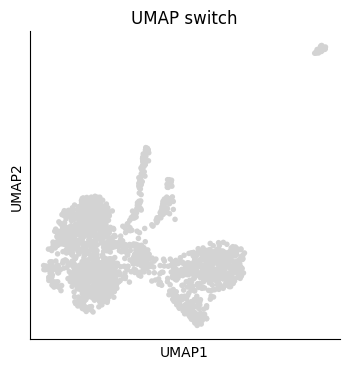

In [281]:
sc.pp.neighbors(adata_proceesed)
sc.tl.umap(adata_proceesed)
sc.pl.umap(adata_proceesed, save=f'_{REPRESENT}.png', title=f'UMAP {REPRESENT}')

### Run SEACells

In [282]:
## Core parameters
n_SEACells = 15
build_kernel_on = 'X_pca'

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells !!not sure how to tune

In [283]:
model = SEACells.core.SEACells(adata_proceesed,
                  build_kernel_on=build_kernel_on,
                  n_SEACells=n_SEACells,
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [284]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/1905 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/1905 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/1905 [00:00<?, ?it/s]

Constructing CSR matrix...


In [285]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 9 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 16/16 [00:00<00:00, 285.38it/s]

Selecting 6 cells from greedy initialization.


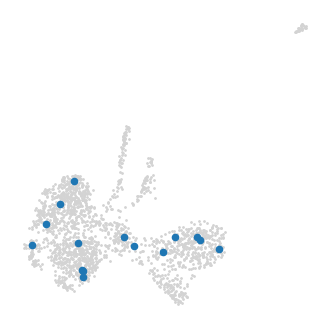

In [286]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(adata_proceesed, model)

In [287]:
model.fit(min_iter=10, max_iter=100)

Randomly initialized A matrix.
Setting convergence threshold at 0.00078
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Converged after 38 iterations.


### Assessing results

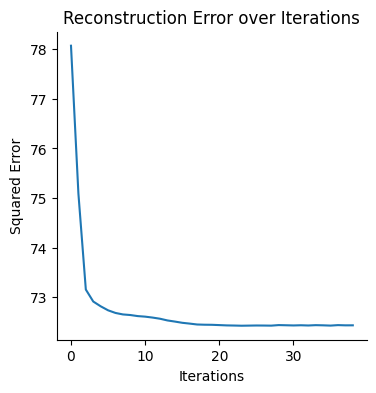

In [288]:
# Check for convergence
model.plot_convergence()

In [289]:
model.get_hard_assignments().head()

,SEACell
index,
AAACCCAAGCAGCACA-1,SEACell-3
AAACGAAAGACCGTTT-1,SEACell-9
AAACGAAAGGGCGAAG-1,SEACell-10
AAACGCTTCCTCGCAT-1,SEACell-1
AAAGAACAGGGAGGAC-1,SEACell-0


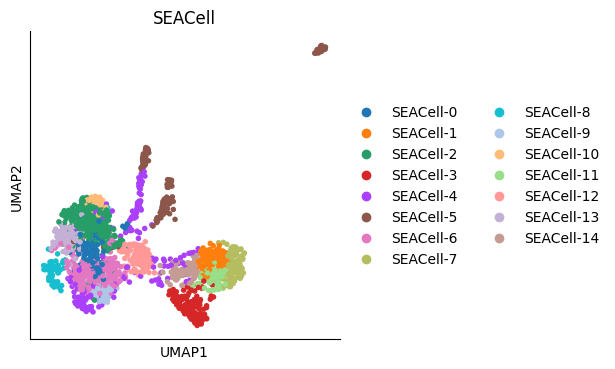

In [290]:
sc.pl.umap(adata_proceesed, color='SEACell', save=f'_SEACells_{REPRESENT}.png')

/Users/CJChen/Desktop/PeerLab/probablistic-model/venv/lib/python3.11/site-packages/SEACells/plot.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.distplot(label_df.groupby('SEACell').count().iloc[:, 0], bins=bins)
/Users/CJChen/Desktop/PeerLab/probablistic-model/venv/lib/python3.11/site-packages/SEACells/plot.py:121: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label_df.groupby('SEACell').count().iloc[:, 0], bins=bins)


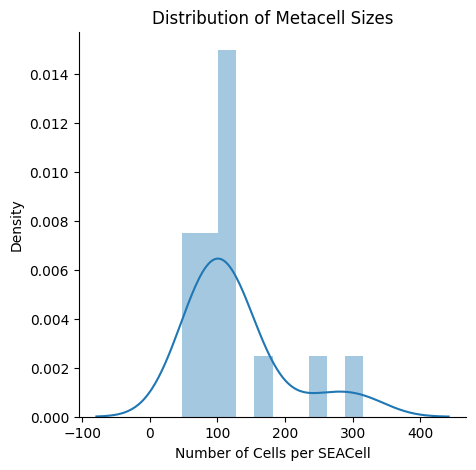

/Users/CJChen/Desktop/PeerLab/probablistic-model/venv/lib/python3.11/site-packages/SEACells/plot.py:131: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return pd.DataFrame(label_df.groupby('SEACell').count().iloc[:, 0]).rename(columns={'index':'size'})


,size
SEACell,
SEACell-0,126
SEACell-1,123
SEACell-2,315
SEACell-3,126
SEACell-4,174
SEACell-5,116
SEACell-6,258
SEACell-7,83
SEACell-8,71


In [291]:
SEACells.plot.plot_SEACell_sizes(adata_proceesed, bins=10)

# Saving Results

In [292]:
model.get_hard_assignments().to_csv(save_dir + f'SEACell_assignments_{REPRESENT}.csv', sep='\t')